In [44]:
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

using nltk and naive bayes classification algorithm to do a very simple Spam/Ham Classification from SMS dataset.


PART 1: DATA PREPROCESSING

since the dataset comes with additional unnamed, column, I need to drop them first

In [45]:
messages = pd.read_csv('spam.csv', encoding='latin-1')
messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
messages = messages.rename(columns={'v1': 'class','v2': 'text'})

In [46]:
messages.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [47]:
messages.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

from above information, we know that:

only about 15% of the text messages is classified as a spam
there are some duplicate messages, since the number of unique values lower than the count values of the text
in the next part, let's check the length of each text messages to see whether it is correlated with the text classified as a spam or not.

In [48]:
messages['length'] = messages['text'].apply(len)

array([<AxesSubplot: title={'center': 'ham'}>,
       <AxesSubplot: title={'center': 'spam'}>], dtype=object)

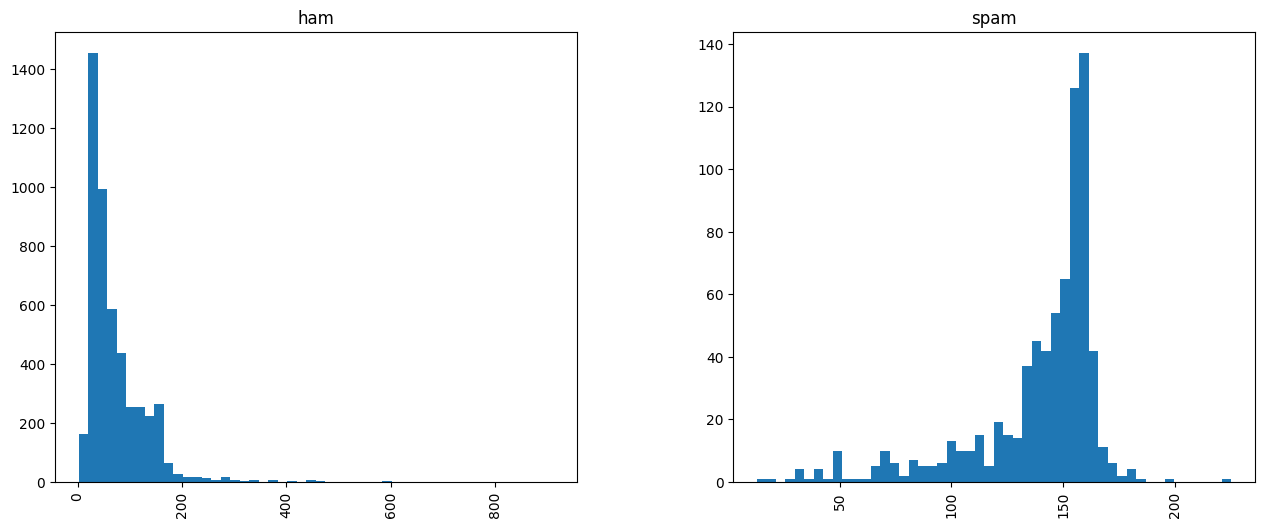

In [49]:
messages.hist(column='length',by='class',bins=50, figsize=(15,6))

from above figure, we can see that most ham (or not spam) messages only have length under 200 (100 to be exact) while spam messages tend to have higher length above 130 or 140 approximately.

PART 2: CREATE TOKENIZER

In [50]:
def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''

    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    #3
    return clean_words


In [51]:
import nltk
nltk.download('stopwords')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
messages['text'].apply(process_text).head()

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: text, dtype: object

PART 3: SPLITTING DATASET

In [53]:
msg_train, msg_test, class_train, class_test = train_test_split(messages['text'],messages['class'],test_size=0.2)

PART 4: DATA PREPROCESSING

wait, we've just created the tokenizer isn't it? let the pipeline do the rest.

PART 5: MODEL CREATION

here I'll just use pipeline in order to minimize effort on doing preprocessing, transforming then training data on both training dataset and test dataset. Using pipeline will handle them all in a few lines of codes.

In [54]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=process_text)), # converts strings to integer counts
    ('tfidf',TfidfTransformer()), # converts integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) # train on TF-IDF vectors with Naive Bayes classifier
])


PART 6: TESTING

In [55]:
pipeline.fit(msg_train,class_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x14d4a41f0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [56]:
predictions = pipeline.predict(msg_test)

In [57]:
print(classification_report(class_test,predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       948
        spam       1.00      0.72      0.84       167

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



<AxesSubplot: >

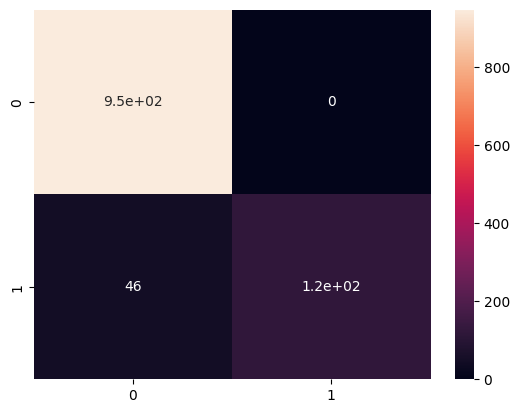

In [59]:
import seaborn as sns
sns.heatmap(confusion_matrix(class_test,predictions),annot=True)